# ICU survivor prediction
# Machine Learning, Exercise 5
 王敏行 id:2018012386 wangmx18@mails.tsinghua.edu.cn
 
**All following codes originally generated by myself.**
Please see rm.md before running this file.

### Part 11: Bayesian Network

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from scipy import stats

# ts = pd.read_csv('data1forEx1to4/test1_icu_data.csv')
# tr = pd.read_csv('data1forEx1to4/train1_icu_data.csv')
# Y_tr = pd.read_csv('data1forEx1to4/train1_icu_label.csv')
# Y_ts = pd.read_csv('data1forEx1to4/test1_icu_label.csv')
ts = pd.read_csv('../Ex1_20210923/data1forEx1to4/test1_icu_data.csv')
tr = pd.read_csv('../Ex1_20210923/data1forEx1to4/train1_icu_data.csv')
Y_tr = pd.read_csv('../Ex1_20210923/data1forEx1to4/train1_icu_label.csv')
Y_ts = pd.read_csv('../Ex1_20210923/data1forEx1to4/test1_icu_label.csv')


x_ts = np.array(ts)
x_tr = np.array(tr)
y_ts = np.array(Y_ts).ravel()
y_tr = np.array(Y_tr).ravel()
print('train:{}\ntest:{}'.format(x_tr.shape,x_ts.shape))

train:(5000, 108)
test:(1097, 108)


Here I choose variance threshold strategy with the package [sklearn.feature_selectrion.VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#) to remove features with low variance. Please see the report for detailed explanation about the algorithm.

In [2]:
def var_Bernoulli(p):
    return p*(1-p)

# def var_plot(x):
#     dim = x.shape[1]
#     var = np.zeros((1,dim))
#     for i in range(dim):
#         var[0,i]=np.var(x[:,i])
#     return var

# vari = np.var(x_tr, axis=0)
# hist, bin_edges = np.histogram(vari)
# width = (bin_edges[1] - bin_edges[0]) * 0.8
# plt.bar(bin_edges[1:], hist/max(hist), width=width)
# cdf = np.cumsum(hist/sum(hist))
# plt.plot(bin_edges[1:], cdf, '-*')
# # plt.xlim([-2, 2])
# # plt.ylim([0, 1])
# plt.grid()
# plt.show()

sel = VarianceThreshold(threshold=var_Bernoulli(0.8))
sel.fit(x_tr)
filtered_X_tr = sel.transform(x_tr)
filtered_X_val = sel.transform(x_ts)
print('filtered:{}'.format(filtered_X_tr.shape))

filtered:(5000, 67)


model: linearSVM

parameters: C=0.1

training sets: unfiltered data `x_tr`(dim=108), filtered data `filtered_X_tr`(dim=67)

In [3]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
svm1 = LinearSVC(C=0.001, max_iter=5000)#,random_state=42)
svm1.fit(x_tr,y_tr)
pred1_tr = svm1.predict(x_tr)
pred1_val = svm1.predict(x_ts)
train1_acc = accuracy_score(y_tr, pred1_tr)
vali1_acc = accuracy_score(y_ts, pred1_val)
print('origin data\ntrain acc:{:0.5f}\nvalidation acc:{:0.5f}'.format(train1_acc, vali1_acc))

svm2 = LinearSVC(C=0.001, max_iter=5000)#,random_state=42)
svm2.fit(filtered_X_tr,y_tr)
pred2_tr = svm2.predict(filtered_X_tr)
pred2_val = svm2.predict(filtered_X_val)
train2_acc = accuracy_score(y_tr, pred2_tr)
vali2_acc = accuracy_score(y_ts, pred2_val)
print('\nfiltered data\ntrain acc:{:0.5f}\nvalidation acc:{:0.5f}'.format(train2_acc, vali2_acc))

C:\Users\Max\anaconda3\envs\nb\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


origin data
train acc:0.78860
validation acc:0.78213

filtered data
train acc:0.78080
validation acc:0.77666


C:\Users\Max\anaconda3\envs\nb\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Part 9: Lasso regression

In [4]:
from sklearn.linear_model import Lasso
sel = Lasso(alpha=0.1).fit(x_tr,y_tr)
# print(sel.coef_)
dim_re = np.nonzero(sel.coef_)[0]
mask = sel.coef_!=0
print('origin features:{},reduced features:{}.'.format(x_tr.shape[1],dim_re.shape[0]))


def Lasso_tf(x, coef):
    new_x =x*coef
    new_x = new_x[:,mask]
    return new_x

new_X_tr = Lasso_tf(x_tr, sel.coef_)
new_X_val = Lasso_tf(x_ts, sel.coef_)

origin features:108,reduced features:29.


Now we have select the features with lasso regression. Next we will characterize the selection by training the svm model on the selected training data `new_X_tr` and testing on transformed testset `new_X_ts`.

In [5]:
svm3 = LinearSVC(C=0.001, max_iter=5000)#,random_state=42)
svm3.fit(new_X_tr,y_tr)
pred3_tr = svm3.predict(new_X_tr)
pred3_val = svm3.predict(new_X_val)
train3_acc = accuracy_score(y_tr, pred3_tr)
vali3_acc = accuracy_score(y_ts, pred3_val)
print('iterations:{}\nLasso selected data\ntrain acc:{:0.5f}\nvalidation acc:{:0.5f}'.format(svm3.n_iter_ ,train3_acc, vali3_acc))

iterations:6
Lasso selected data
train acc:0.73180
validation acc:0.73382


In [6]:
def Lasso_pred(x,model,thr=0.5):
    prob = model.predict(x)
    pred = prob>thr
    return pred

pred4_tr = Lasso_pred(x_tr,sel)
pred4_val = Lasso_pred(x_ts,sel)
train4_acc = accuracy_score(y_tr, pred4_tr)
vali4_acc = accuracy_score(y_ts, pred4_val)
print('Lasso regression classifier\ntrain acc:{:0.5f}\nvalidation acc:{:0.5f}'.format(train4_acc, vali4_acc))

Lasso regression classifier
train acc:0.75560
validation acc:0.75479


### Part 10: Random Forest
First try original data in training and testing. Then try the data transformed from Lasso regression (29-dimensional).

RF on raw data
train acc:0.80080
validation acc:0.78669

-------------feature importance-----------
Feature: 0, Score: 0.00737
Feature: 1, Score: 0.00029
Feature: 2, Score: 0.00363
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00138
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.01192
Feature: 7, Score: 0.01940
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.05315
Feature: 10, Score: 0.04836
Feature: 11, Score: 0.05581
Feature: 12, Score: 0.06260
Feature: 13, Score: 0.05204
Feature: 14, Score: 0.00245
Feature: 15, Score: 0.00618
Feature: 16, Score: 0.00016
Feature: 17, Score: 0.02615
Feature: 18, Score: 0.00189
Feature: 19, Score: 0.00166
Feature: 20, Score: 0.00222
Feature: 21, Score: 0.01686
Feature: 22, Score: 0.08882
Feature: 23, Score: 0.00572
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.01912
Feature: 26, Score: 0.01058
Feature: 27, Score: 0.00596
Feature: 28, Score: 0.00011
Feature: 29, Score: 0.01213
Feature: 30, Score: 0.00949
Feature: 31, Score: 0.00076
Feature: 32, S

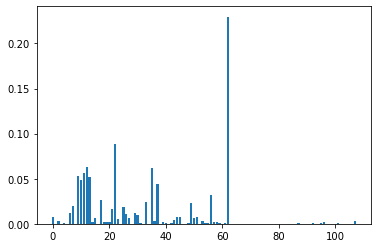

In [7]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier(n_estimators=100, max_leaf_nodes=10)
rf1.fit(x_tr,y_tr)
pred5_tr = rf1.predict(x_tr)
pred5_val = rf1.predict(x_ts)
train5_acc = accuracy_score(y_tr, pred5_tr)
vali5_acc = accuracy_score(y_ts, pred5_val)
print('RF on raw data\ntrain acc:{:0.5f}\nvalidation acc:{:0.5f}'.format(train5_acc, vali5_acc))

importance = rf1.feature_importances_
# summarize feature importance
print('\n-------------feature importance-----------')
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [9]:
rf2 = RandomForestClassifier(n_estimators=100,max_leaf_nodes=10)
rf2.fit(new_X_tr,y_tr)
pred6_tr = rf2.predict(new_X_tr)
pred6_val = rf2.predict(new_X_val)
train6_acc = accuracy_score(y_tr, pred6_tr)
vali6_acc = accuracy_score(y_ts, pred6_val)
print('RF on Lasso-decomposed data\ntrain acc:{:0.5f}\nvalidation acc:{:0.5f}'.format(train6_acc, vali6_acc))


RF on Lasso-decomposed data
train acc:0.77560
validation acc:0.78213


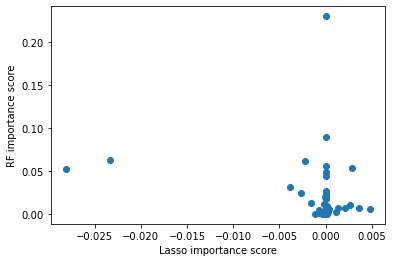

In [12]:
plt.figure()
plt.scatter(sel.coef_,importance)
plt.xlabel('Lasso importance score')
plt.ylabel('RF importance score')
plt.show()